PART I:

Your task is the following:

1. Provide a set of recommendations on how to improve our business or product based on the attached dataset. This is intended to be fairly open-ended - there's no right or wrong answer! We're more concerned with your approach and the insights you uncover.

2. Choose one of the recommendations/insights you uncovered (in #1) and outline an experiment you would like to run to test your suggested product/business recommendation. Please state your hypothesis, describe how you would structure your experiment, list your success metrics and describe the implementation.

3. Let's assume that the experiment you ran (in #2) proved your hypothesis was true. How would you suggest implementing the change on a larger scale? What are some operational challenges you might encounter and how would you mitigate their risk?

# Part 1

4 initial hypotheses I'm going to investigate
1. Different drivers have different refund rates.
2. Different restaurants have different refund rates.
3. Percentage of orders refunded will increase with either time between placed order to delivered or driver at restaurant to delivered.
4. Orders placed ahead have lower average delivery time and lower refund percentages. 

Some early assumptions I'm making since I'm unclear how DoorDash's entire system worked at this stage in the company's life - 

1a. If the customer places an order and selects 'Is ASAP = True', the order is placed with the restaurant pretty instantaneously.

1b. If the customer selects 'Is ASAP = False', then the order is placed with the restaurant at a generally appropriate time for the customer to get their meal on time. I noticed that for really large orders, many of them don't have 'Placed order with restaurant' times. I'm going to assume that this is because there's a special way of placing these orders which doesn't involve adding a time to the dataset.
2. The driver will arrive at the restaurant around the time when the meal is ready and then instantly leaves for the consumer. The assumption is that this process is pretty efficient. 

I'm using these assumptions to fill in null times where applicable. I'll eventually realize how poor these assumptions are, but let's not ruin the surprise.

In [1]:
import numpy as np
import pandas as pd
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.layouts import row
output_notebook()
# Please don't hate me, I switch between bokeh and matplotlib depending on what I want from the graph. 
# I swear I'm not a sociopath.

Loading BokehJS ...

In [2]:
df_doordash = pd.read_csv('/Users/ben.jiang/Downloads/Analytics Sample Data.csv')

In [3]:
df_doordash.head()

,Customer placed order datetime,Placed order with restaurant datetime,Driver at restaurant datetime,Delivered to consumer datetime,Driver ID,Restaurant ID,Consumer ID,Is New,Delivery Region,Is ASAP,Order total,Amount of discount,Amount of tip,Refunded amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0


In [4]:
def clean_datetime(column):
    df_split = df_doordash[column].str.split(" ", 1, expand=True)
    df_split["hour"], df_split["minute"], df_split["second"] = (
        df_split[1].str.split(":", 3).str
    )
    df_split.drop(axis=1, columns=1, inplace=True)
    df_split.rename(columns={0: "days"}, inplace=True)
    df_split["year"] = 2019
    df_split["month"] = np.where(df_split["days"] == "31", "5", "6")
    return pd.to_datetime(df_split) + datetime.timedelta(hours=-8)


Honestly, I've never seen this date time format before. I'm going to convert it into something a little more human readable.

Initially I didn't convert everything from UTC and I ran into some problems down the line where the customer was ordering from the 31st of the previous month and receiving their order on the 1st of the month. Based on the way the dataset looks and the way the question was phrased, I'm assuming this data was queried using orders delivered to consumer in a month that has 30 days, based on UTC time, where the previous month had 31 days. I'm picking an arbitrary month with 31 days to be the base month (June) and assuming that if your day is 31, you're in May.

In [5]:
columns = [
    "Customer placed order datetime",
    "Placed order with restaurant datetime",
    "Driver at restaurant datetime",
    "Delivered to consumer datetime",
]
for column in columns:
    df_doordash[column] = clean_datetime(column)


I think there are two ways to think about refunds, from a $ perspective and an absolute, 'was there a refund at all?' perspective, because it helps with understanding why the refund occurred since I have no error codes in this dataset. 

Intuitively, I can imagine 2 major reasons why DoorDash would refund a customer -

1. The restaurant messed up the order, so the customer didn't receive what they were looking for.
2. The Dasher showed up late/never showed up/other delivery related refunds.

Isolating which of these caused the problem is helpful when trying to make sure the other isn't unfairly penalized for a refunded order.

In [6]:
df_doordash["total_cost"] = df_doordash["Order total"] + df_doordash["Amount of tip"]
df_doordash["percentage_refunded_dollars"] = (
    df_doordash["Refunded amount"] / df_doordash["total_cost"]
)
df_doordash["refunded_bool"] = np.where(df_doordash["Refunded amount"] > 0, 1, 0)


In [7]:
# I want to see what the percentage of order $ refunded breakout is like to better understand them.
p = figure(
    tools="pan,box_zoom,reset,save",
    y_range=[-0.05, 1.05],
    title="Of the Refunded Orders, What Percentage of Each Order was Refunded?",
    x_axis_label="index",
    y_axis_label="percentage_refunded_dollars",
)


p.line(
    df_doordash[df_doordash["percentage_refunded_dollars"] > 0]
    .sort_values("percentage_refunded_dollars")
    .reset_index()
    .index,
    df_doordash[df_doordash["percentage_refunded_dollars"] > 0]
    .sort_values("percentage_refunded_dollars")
    .reset_index()["percentage_refunded_dollars"],
)


GlyphRenderer(id='1037', ...)

In [8]:
show(p)

To me, this looks like 3 different categories of errors (0-40%, 40-90%, 100% refunded) but I don't have a great explanation for what would be causing the 3 distinct refund categories.

While it would make sense that restaurant errors (wrong/missing order) would explain the 0-40% refunds and major delivery errors would explain that fully refunded orders, every order in the dataset has a 'delivered to customer' time and 95% of the fully refunded orders actually included a tip. I can't imagine the Dasher getting a tip if the customer knew they were going to demand a full refund. I also can't imagine DoorDash giving partial refunds for late delivery drivers (how would you even quantify how much of a refund to give?) but it seems plausible. I'm going to do some more poking to see if I can identify situations where DoorDash gave a delivery related refund. 

In [9]:
def summary_statistics(df):
    print(
        "Number of Orders:",
        len(df),
        "\n" "% of Orders Refunded (any amount): %",
        np.round(100 * df["refunded_bool"].mean(), 2),
        "\n" "% of Orders Refunded ($): %",
        np.round(100 * df["Refunded amount"].sum() / df["total_cost"].sum(), 2),
        "\n" "% Is ASAP: %",
        np.round(100 * df["Is ASAP"].sum() / len(df), 2),
        "\n" "% Is New: %",
        np.round(100 * df["Is New"].sum() / len(df), 2),
    )


In [10]:
summary_statistics(df_doordash)

Number of Orders: 18078 
% of Orders Refunded (any amount): % 2.74 
% of Orders Refunded ($): % 1.12 
% Is ASAP: % 79.85 
% Is New: % 19.43


In [11]:
def plot_percentage_refunded(column):
    # Plot % of refunds by dollars and absolute
    df = df_doordash.groupby([column]).agg(
        {
            "Refunded amount": "sum",
            "total_cost": "sum",
            "refunded_bool": ["sum", "count"],
        }
    )
    df["percentage_refunded_dollars"] = 100 * df["Refunded amount"] / df["total_cost"]
    df["percentage_refunded_bool"] = (
        100 * df["refunded_bool"]["sum"] / df["refunded_bool"]["count"]
    )
    df.columns = [" ".join(col).strip() for col in df.columns.values]
    df[
        ["percentage_refunded_dollars", "percentage_refunded_bool"]
    ].transpose().plot.bar(rot=0)


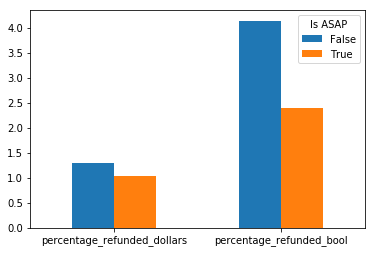

In [12]:
plot_percentage_refunded('Is ASAP')

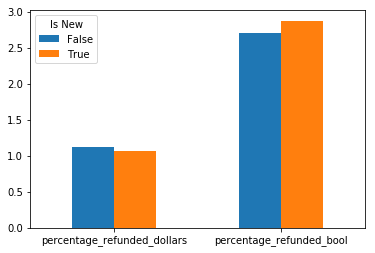

In [13]:
plot_percentage_refunded('Is New')

__So humorously enough, it appears that ordering in advance actually increases your chances of refunding significantly, but doesn't increase the dollar refund % by a corresponding amount.__ New customers are slightly more likely to refund, but have smaller refund $ percentages. I think it's super odd that ordering ahead doesn't decrease refund rate, but maybe that's the insight I'm looking for. You are twice as likely to have a negative experience when not ordering ASAP.

In [14]:
# I'm dropping this one row because I don't understand how this person paid $0 and got refunded $85.
df_doordash = df_doordash[
    ~(df_doordash["Refunded amount"] > (df_doordash["total_cost"] + 1))
]


In [15]:
def refund_groupby(dataframe, column):
    df = (
        dataframe.groupby([column])
        .agg(
            {
                "Refunded amount": "sum",
                "total_cost": "sum",
                "refunded_bool": ["sum", "count"],
            }
        )
        .reset_index()
    )
    df["percentage_refunded_dollars"] = df["Refunded amount"] / df["total_cost"]
    df["percentage_refunded_absolute"] = (
        df["refunded_bool"]["sum"] / df["refunded_bool"]["count"]
    )
    return df


In [16]:
def percentage_refunded_by_column(dataframe, column, color=None):
    def plot_percentages(dataframe, column, metric, x_axis_1, x_axis_2, color):
        y_height = dataframe[metric].max() + .05
        dataframe.sort_values(metric, inplace=True)
        dataframe.reset_index(inplace=True)
        p1 = figure(
            tools="pan,box_zoom,reset,save",
            y_range=[-0.05, y_height],
            title=column,
            x_axis_label="index",
            y_axis_label=metric,
            plot_width=475,
            plot_height=475,
        )
        p1.line(dataframe.index, dataframe[metric], color=color)
        p2 = figure(
            tools="pan,box_zoom,reset,save",
            y_range=[-0.05, y_height],
            title=column,
            x_axis_label=x_axis_2,
            y_axis_label=metric,
            plot_width=475,
            plot_height=475,
        )
        p2.circle(dataframe[x_axis_1][x_axis_2], dataframe[metric], color=color)
        show(row(p1, p2))

    df_refunds = refund_groupby(dataframe, column)
    plot_percentages(
        df_refunds, column, "percentage_refunded_dollars", "total_cost", "sum", color
    )
    plot_percentages(
        df_refunds,
        column,
        "percentage_refunded_absolute",
        "refunded_bool",
        "count",
        color,
    )


I'm looking for a relationship between customer, driver, or restaurant refund rates. 

In [17]:
percentage_refunded_by_column(df_doordash, "Driver ID", "navy")

In [18]:
percentage_refunded_by_column(df_doordash, "Restaurant ID", "olive")


In [19]:
percentage_refunded_by_column(df_doordash, "Consumer ID", "teal")


Okay this is super interesting to me. Let's start with the driver and restaurant graphs. We can see that plotting the percentage refunded by dollar and by order graphs are extremely similar. To me, that suggests refunds are relatively independent of restaurant and driver. The majority of restaurants/drivers are 'underneath the elbow' when you graph refund percentage against the denominator, which means that they're in line with the others. Looking at the area underneath the elbow helps you avoid focusing on outliers with few datapoints and isolates the truly negative data points. 

__RECOMMENDATION: Identify and phase out Restaurants/Drivers who are scoring above the 75th percentile for both number of orders and percentage refunded.__

I also want to point out that only 6% of your customers have filed for any sort of refund. On one hand this is good because something can go wrong that you might otherwise have to refund them for, but on the other hand these people tend to simply move on from a service if it goes wrong for them.

In [20]:
print(
    "Number of Null Placed Order Times:",
    len(df_doordash[df_doordash["Placed order with restaurant datetime"].isnull()]),
    "\n" "Number of Null Driver Order Times:",
    len(df_doordash[df_doordash["Driver at restaurant datetime"].isnull()]),
    "\n",
)


Number of Null Placed Order Times: 40 
Number of Null Driver Order Times: 4530 



In [21]:
summary_statistics(df_doordash[df_doordash["Driver at restaurant datetime"].isnull()])


Number of Orders: 4530 
% of Orders Refunded (any amount): % 2.96 
% of Orders Refunded ($): % 1.4 
% Is ASAP: % 79.01 
% Is New: % 19.67


Okay so that's actually a lot worse than the total dataset with regards to refund %. My guess is that if the driver's running late, then they don't clock in. The odd part is that ordering ahead % on this subset is actually higher than the average, which continues to suggest that in this month, the restaurant wasn't being informed far enough in advance and the total cooking to delivery time was being underestimated.

Normally I'd handle the nulls with some interpolation of the non-null data, but it seems significant in this instance so I'm going to leave them and work around that. 

In [22]:
# I want to create 3 new columns, to measure the time difference between the other datetimes and time delivered
# Everything is in minutes for simplicity. I'm going to assume that 59 seconds will not be the difference in a refund.
# For even further aggregation, I'm going to round everything to the nearest 5 minutes.
df_doordash["customer_order_datediff"] = 5 * np.round(
    (
        df_doordash["Delivered to consumer datetime"]
        - df_doordash["Customer placed order datetime"]
    ).dt.seconds
    / 300
)
df_doordash["placed_order_datediff"] = 5 * np.round(
    (
        df_doordash["Delivered to consumer datetime"]
        - df_doordash["Placed order with restaurant datetime"]
    ).dt.seconds
    / 300
)
df_doordash["driver_order_datediff"] = 5 * np.round(
    (
        df_doordash["Delivered to consumer datetime"]
        - df_doordash["Driver at restaurant datetime"]
    ).dt.seconds
    / 300
)


Doing some more quick and dirty cleaning.

In [23]:
df_doordash["placed_order_datediff"] = np.where(
    df_doordash["Placed order with restaurant datetime"]
    < df_doordash["Customer placed order datetime"],
    df_doordash["customer_order_datediff"],
    df_doordash["placed_order_datediff"],
)
df_doordash = df_doordash[
    df_doordash["Placed order with restaurant datetime"]
    < df_doordash["Delivered to consumer datetime"]
]


In [24]:
df_doordash.groupby(["Is ASAP", "refunded_bool"]).agg(
    {"placed_order_datediff": "describe"}
)


placed_order_datediff                                    \
                                      count       mean        std   min   25%   
Is ASAP refunded_bool                                                           
False   0                            3452.0  55.227404  46.728054  10.0  40.0   
        1                             151.0  69.006623  46.715522  25.0  45.0   
True    0                           14083.0  39.243414  13.289447   0.0  30.0   
        1                             342.0  49.035088  19.795996  20.0  35.0   

                                           
                        50%   75%     max  
Is ASAP refunded_bool                      
False   0              50.0  65.0  1080.0  
        1              60.0  80.0   525.0  
True    0              35.0  45.0   230.0  
        1              45.0  55.0   165.0

In [25]:
df_doordash.groupby(["Is ASAP", "refunded_bool"]).agg(
    {"driver_order_datediff": "describe"}
)


driver_order_datediff                                   \
                                      count       mean        std  min   25%   
Is ASAP refunded_bool                                                          
False   0                            2557.0  22.528354  10.257430  0.0  15.0   
        1                             113.0  28.938053  17.771508  5.0  15.0   
True    0                           10601.0  24.418451  10.527546  0.0  15.0   
        1                             248.0  28.346774  13.746133  5.0  20.0   

                                          
                        50%   75%    max  
Is ASAP refunded_bool                     
False   0              20.0  25.0   85.0  
        1              25.0  40.0  150.0  
True    0              25.0  30.0  170.0  
        1              25.0  35.0   90.0

## We can see that a major difference between the refunded and non refunded orders is the amount of time between placing the order and delivery. 

In [26]:
def time_to_refunded_by_column(dataframe, ASAP, column, color=None):

    df_refunds = refund_groupby(dataframe[dataframe["Is ASAP"] == ASAP], column)
    p1 = figure(
        tools="pan,box_zoom,reset,save",
        title="% of Dollars refunded vs " + column + " ASAP=" + str(ASAP),
        x_axis_label=column,
        y_axis_label="percentage_refunded_dollars",
        plot_width=475,
        plot_height=475,
    )

    p1.line(df_refunds[column], df_refunds["percentage_refunded_dollars"])

    p2 = figure(
        tools="pan,box_zoom,reset,save",
        title="% of Orders refunded vs " + column + " ASAP=" + str(ASAP),
        x_axis_label=column,
        y_axis_label="percentage_refunded_absolute",
        plot_width=475,
        plot_height=475,
    )

    p2.line(df_refunds[column], df_refunds["percentage_refunded_absolute"])

    p3 = figure(
        tools="pan,box_zoom,reset,save",
        title="Number of Orders at " + column + " ASAP=" + str(ASAP),
        x_axis_label=column,
        y_axis_label="number of orders",
        plot_width=800,
        plot_height=475,
    )

    p3.line(df_refunds[column], df_refunds["refunded_bool"]["count"])
    show(row(p1, p2))
    show(p3)


In [27]:
time_to_refunded_by_column(df_doordash, True, "placed_order_datediff")


In [28]:
time_to_refunded_by_column(df_doordash, False, "placed_order_datediff")


In [29]:
time_to_refunded_by_column(df_doordash, True, "driver_order_datediff")


In [30]:
time_to_refunded_by_column(df_doordash, False, "driver_order_datediff")


## What do all these tables and graphs tell us? 

Customers have a general 'tolerance' for waiting on their food. Any longer than that and the chances of them demanding a refund increase dramatically. It differs based on how you ordered. For instance, for people ordering ASAP, you reach a 2% chance of asking for a refund around 35 minutes in, whereas people who ordered ahead of time reach that point around 25 minutes in. __What's interesting is that although ASAP and ordering ahead have similar driver arriving at the restaurant to delivery times, ordering ahead has a 10-15min increase in the time difference between placing an order with the restaurant and delivery.__ I'm assuming this is due to people ordering ahead for peak business hours, but I'm going to test thiis out in a second. 

__RECOMMENDATION: If not already doing so/if feasible, increased the lead time on Non ASAP orders to ensure the customer gets their food before they get cranky. Although it takes ~100min of restaurant to delivery time for Non ASAP to reach the same refund rate as ~80min of restaurant to delivery time for ASAP orders, a higher % of Non ASAP orders reach that point.__

This dataset does not tell me whether or not this increased time is accounted for to ensure the delivery is still on time (which I suspect not), what the difference between actual delivery time and the time the customer was expecting was, or if the increased time is due to the restaurant taking longer to make the food or the Dasher taking longer to get the restaurant.

All we know is that once the Dasher gets to the restaurant, it takes the same amount of time for them to get to the customer and that ordering ahead actually has a higher refund rate and is a worse overall customer experience.

In [31]:
# I'm creating some more metrics to identify poor restaurant/driver experiences
df_doordash["placed_order_hour"] = df_doordash[
    "Placed order with restaurant datetime"
].dt.hour
df_doordash["created_order_hour"] = df_doordash[
    "Customer placed order datetime"
].dt.hour
df_doordash["placed_driver_datediff"] = np.round(
    (
        df_doordash["Driver at restaurant datetime"]
        - df_doordash["Placed order with restaurant datetime"]
    ).dt.seconds
    / 60
)
df_doordash["created_placed_datediff"] = np.round(
    (
        df_doordash["Placed order with restaurant datetime"]
        - (df_doordash["Customer placed order datetime"])
    ).dt.seconds
    / 60
)


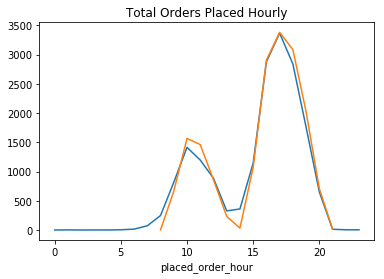

In [32]:
# Overlaying orders created at with orders placed, you can see orders placed troughs more sharply than orders created.
fig1, ax1 = plt.subplots()
df_doordash.groupby(["created_order_hour"]).agg({"Is ASAP": "count"}).plot(
    title="Total Orders Created Hourly", legend=False, ax=ax1
)
df_doordash.groupby(["placed_order_hour"]).agg({"Is ASAP": "count"}).plot(
    title="Total Orders Placed Hourly", legend=False, ax=ax1
)


In [35]:
df_hour_refunds = (
    df_doordash[df_doordash["Is ASAP"] == False]
    .groupby(["placed_order_hour"])
    .agg(
        {
            "Refunded amount": "sum",
            "total_cost": "sum",
            "refunded_bool": ["sum", "count"],
            "placed_order_datediff": "median",
            "driver_order_datediff": "median",
            "placed_driver_datediff": "median",
        }
    )
    .reset_index()
)
df_hour_refunds["percentage_refunded_dollars"] = (
    df_hour_refunds["Refunded amount"] / df_hour_refunds["total_cost"]
)
df_hour_refunds["percentage_refunded_absolute"] = (
    df_hour_refunds["refunded_bool"]["sum"] / df_hour_refunds["refunded_bool"]["count"]
)


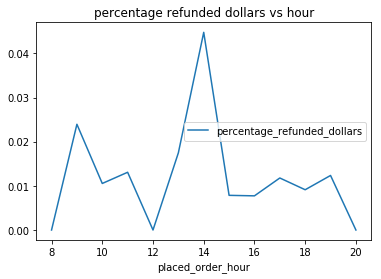

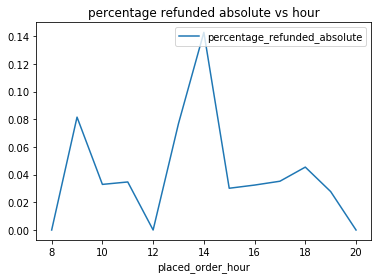

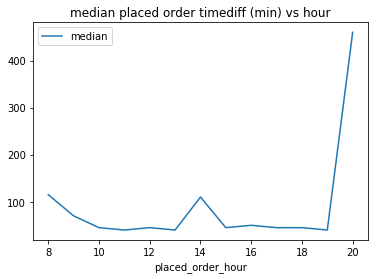

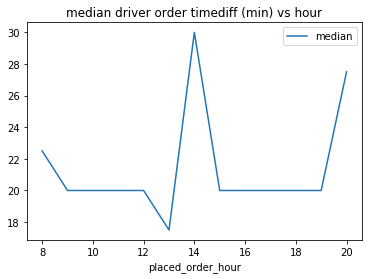

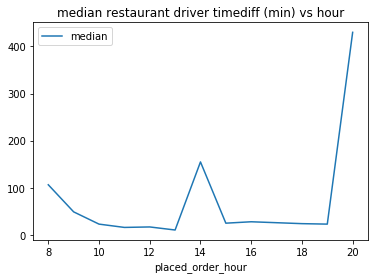

In [36]:
# These graphs identify two hours (9, 14) where refund percentages are high.
# Corresponding with increased delivery time and restaurant - delivery time.
df_hour_refunds.plot(
    x="placed_order_hour",
    y="percentage_refunded_dollars",
    title="percentage refunded dollars vs hour",
)
df_hour_refunds.plot(
    x="placed_order_hour",
    y="percentage_refunded_absolute",
    title="percentage refunded absolute vs hour",
)
df_hour_refunds.plot(
    x="placed_order_hour",
    y="placed_order_datediff",
    title="median placed order timediff (min) vs hour",
)
df_hour_refunds.plot(
    x="placed_order_hour",
    y="driver_order_datediff",
    title="median driver order timediff (min) vs hour",
)
df_hour_refunds.plot(
    x="placed_order_hour",
    y="placed_driver_datediff",
    title="median restaurant driver timediff (min) vs hour",
)


I looked into it a little bit and hour 14 was a massive outlier (a few, very high value orders that probably took a while to prepare, one of which was almost fully refunded, not enough info to draw conclusions). However, hour 9 appears to be a legitimately underserved time of the day, with extremely high restaurant wait times. 

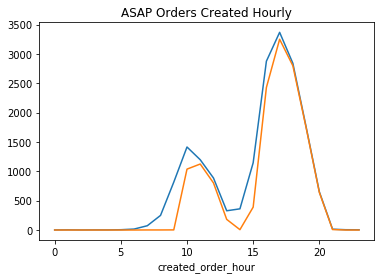

In [37]:
# You would expect the number of ASAP orders to generally follow the total number of orders,
# But in this case it's flat at 0. My guess is that there are no restaurants open to take ASAP orders at 9.
fig1, ax1 = plt.subplots()
df_doordash.groupby(["created_order_hour"]).agg({"Is ASAP": "count"}).plot(
    title="Total Orders Created Hourly", legend=False, ax=ax1
)
df_doordash.groupby(["created_order_hour"]).agg({"Is ASAP": "sum"}).plot(
    title="ASAP Orders Created Hourly", legend=False, ax=ax1
)


In [38]:
print(
    "Number of Orders Created at 9: ",
    len(df_doordash[df_doordash["created_order_hour"] == 9]),
    "\n" "Number of ASAP Orders Created at 9: ",
    len(
        df_doordash[
            (df_doordash["created_order_hour"] == 9) & (df_doordash["Is ASAP"] == True)
        ]
    ),
    "\n" "Number of Orders Placed W/ Restaurant at 9: ",
    len(df_doordash[df_doordash["placed_order_hour"] == 9]),
    "\n" "Median Time (min) from Order Creation to Restaurant at 9: ",
    df_doordash[df_doordash["placed_order_hour"] == 9][
        "created_placed_datediff"
    ].median(),
    "\n" "Median Time (min) from Order Creation to Restaurant, all other hours: ",
    df_doordash[
        (df_doordash["Is ASAP"] == False) & (df_doordash["created_order_hour"] != 9)
    ]["created_placed_datediff"].median(),
    "\n" "Number of Restaurants Receiving Orders at 9: ",
    df_doordash[(df_doordash["placed_order_hour"] == 9)]["Restaurant ID"].nunique(),
    "\n"
    "Number of Restaurants Receiving Orders at 12, when there are ~30% more orders being placed: ",
    df_doordash[(df_doordash["placed_order_hour"] == 12)]["Restaurant ID"].nunique(),
)


Number of Orders Created at 9:  816 
Number of ASAP Orders Created at 9:  2 
Number of Orders Placed W/ Restaurant at 9:  665 
Median Time (min) from Order Creation to Restaurant at 9:  24.0 
Median Time (min) from Order Creation to Restaurant, all other hours:  43.0 
Number of Restaurants Receiving Orders at 9:  100 
Number of Restaurants Receiving Orders at 12, when there are ~30% more orders being placed:  189


More supporting evidence that 9am is underserved by restaurants (people are choosing Not ASAP because it's the only option) - the median time between an order being created and sent to the restaurant is practically half that of other hours, where people are making the conscious choice to postpone their delivery. If the decision wasn't being made for you, would you ever choose to wait ~24 minutes to get your food? At 12, there are 90% more restaurants for only 30% more orders and restaurant to driver time is normal relative to the other hours. 

__RECOMMENDATION: Establish closer relationships with restaurants, build ghost kitchens, fix your app - do whatever it takes to start selling breakfast/brunch at 9am. Get the ~2.5% hourly refund rate down to the overall ~1.4% rate.__

# Part 2

Hypothesis - Increasing the number of restaurant options at 9am to match the other hours will decrease the average placed_order_datediff during the hour from ~60 min to ~40 min, or the overall average placed_order_datediff. 

For my control and my test group, I would use the Mountain View and San Jose delivery regions. They have a relatively similar number of 9am orders over the month (147 to 55). We would need to get a similar number of active restaurants and active Dashers as the other hours (~150, ~130), then enable both of them simultaneously. We’d have to sign agreements with the restaurants beforehand and then set up an incentive for the Dashers that goes into effect at the same time. I know the number of Dashers is essentially a confounding variable, but since I don’t know the magic formula for what number of Dashers in what size area can handle how many orders in this amount of time, I need to control for that as well. 

I plugged everything into a continuous, two tailed sample size calculator and it said I would need a sample size of 24 in each group to reach alpha of 0.05 and power of 0.8, so the experiment could run for half a month and reach significance.

# Part 3

Okay, the experiment has been wildly successful, the 9am customers now refund at the same historical rate as everyone else and we've established that there's a market for breakfast. What next?

Clearly, the reason that we're not selling breakfast right now is that we're limited by our restaurant partnerships. If we had breakfast sellers, this wouldn't even be a problem. We either need new partners or to convince existing partners to open earlier and start letting us deliver earlier. We do so by quantifying the demand for their services, what they stand to gain, and maybe back up our words with a guarantee of some sort? 

"Over this last month, we sold 61,350.95 worth of 9am food in Palo Alto. That's $2,000 a day. We would be willing to place you at the top of the restaurant list in our app, which usually ensures X% of revenue. If you don't see that amount of increased sales, we are willing to cover the difference. Would that make it worth it to open your restaurant at 9?"

Trying to sign new restaurants and get enough Dashers would be difficult, especially on a nationwide scale. I'm not sure how DoorDash traditionally signs on new restaurants - is it a waterfall effect where one restaurant signs on and everyone else joins in a scramble to compete? I'm reasonably sure DoorDash currently waits until they have a decent selection of restaurants in the area before turning on service in the area, so in new areas you could possibly bake serving at 9am into the contract for brunch places. To motivate dashers to work at this off-hour, you need some kind of incentive initially. Minimizing risk would be giving them a higher percentage of sales as opposed to flat hourly bonus, but it depends on how confident you are in your forecasting demand model. There's definitely a general model for how many Dashers over how much area over how many orders it takes to reach a certain maximum delivery time, but I wasn't able to piece it together from this exercise. 

PART II:

4. Directions: We recommend you sketch out your logic in words in addition to the writing the SQL. If you can not complete the exercise in a single query, get as far as you can with querying and then explain how you would complete the question in the most programmatic way (in other words, in the fewest number of queries and/or other analytical steps). 

a. Write a query to calculate the average earnings per hour by day of week.

b. Please write a query to calculate the average earnings per hour during lunch (11am-2pm) in submarket_id 3.

c. Let’s say we want to target dashers who are in the bottom 50th percentile of total pay per hour in the last 30 days with a promotion. Please write a query to identify who these dashers are along with their email address. 

I'm assuming Postgres 8.0.2 for the SQL client (the version Redshift is based off of). I tested my SQL off of Redshift abdasfd, the only SQL functions I used that I could see being different from whatever you're running are the percent rank and maybe the datetime conversions. 

1. Okay this one is pretty interesting because it seems possible for one 'dash' to span multiple days. The problem is super trivial if the dash restarts on a daily basis. I think my major assumption is going to be that around midnight, when it's possible for a Dash to overlap two days, earnings per hour are pretty consistent, so I'm going to split the earnings between days evenly based on percent of time spent in that day. The other big assumption is that all start/end times are stored as local date time, or that we're okay with grouping on the UTC day of week. If this assumption isn't true, then we'd have to do something really janky to get the local time zone (you can do a decent approximation by mapping the first one or two digits of the zipcode to a time zone in a big CASE WHEN LPAD(STR(zipcode),5,'0') statement). 

2. One major assumption we could make is that earnings are evenly distributed among the 'dash'. For instance, a dash that started at 10am and ended at 3pm would have lasted 5 hours, 3 of which were during lunch, and their average earnings per hour during lunch would still be 1/5 of their total earnings. I think it's a pretty poor assumption to make, considering that the goal of this would be to isolate earnings differences between lunch and other time periods. Instead, I'm only going to focus on dashes that started and finished within the lunch period. I'm keeping the time zone assumption from part 1.

select 
sum(a.total_pay)/sum(datediff('hours',a.dash_end_time,a.dash_start_time)) 
from Dash a
inner join 
Dasher b
on a.dasher_id = b.id
where 
datepart(hour, a.dash_start_time) >= 11 and 
datepart(hour, a.dash_end_time) < 14
and b.submarket_id = 3

3. Going back to the possibility of a dash covering multiple days, I'm assuming you get paid based off when the 'dash' ended, not when it started.

select 
a.dasher_id,
b.email_address
from
(select 
dasher_id, 
sum(total_pay)/sum(datediff('hours',dash_end_time,dash_start_time)) as avg,
percent_rank() 
over (partition by dasher_id order by avg) 
from Dash
where datediff('days',dash_end_time,getdate()) <= 30
group by dasher_id
having percent_rank <= 0.5) a
inner join
Dasher b
on a.dasher_id = b.id